In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("user_label_0821.csv")
data.head()

,customer_id,order_cnt,check_cnt,writeoff_cnt,accu_gmv,Ist_ord_dt_diff,Ist_check_dt_diff,Ist_wo_dt_diff
0,4,4,0,8,0.08,91.0,NaN,84.0
1,11,6,0,1,311.06,117.0,NaN,118.0
2,5,105,1,3,3011473.49,78.0,68.0,93.0
3,1,17,1,0,1468.08,96.0,76.0,NaN
4,19,22,0,0,4250.00,82.0,NaN,NaN


## 1. 间隔天数为空填充为9999

In [3]:
data1 = data.fillna(9999)
data1['customer_id'] = data1['customer_id'].astype(str)
data1['customer_id']

0        4
1       11
2        5
3        1
4       19
      ... 
247    457
248    471
249    466
250    456
251    125
Name: customer_id, Length: 252, dtype: object

## 2. 各标签的用户分布

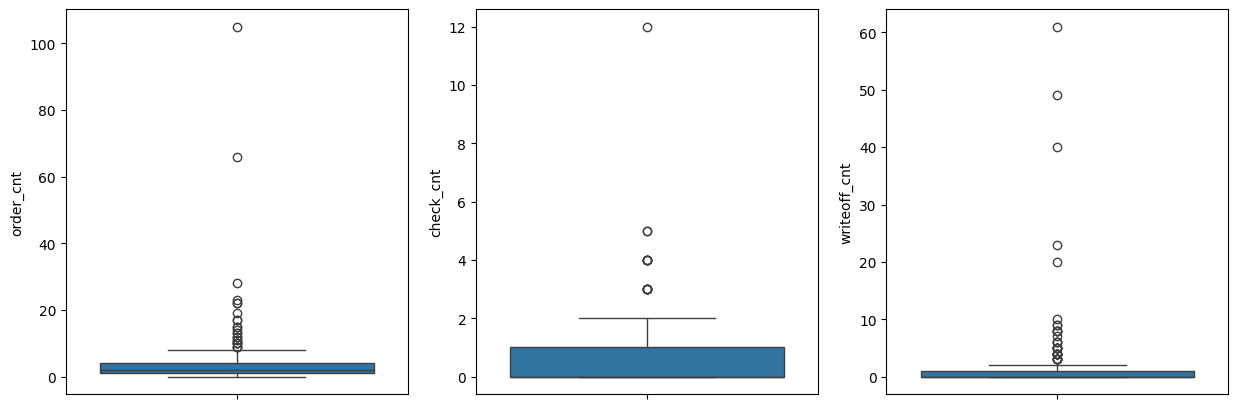

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data1['order_cnt'], ax=axes[0])
sns.boxplot(data1['check_cnt'], ax=axes[1])
sns.boxplot(data1['writeoff_cnt'], ax=axes[2])
plt.show()

In [5]:
data1.head()

,customer_id,order_cnt,check_cnt,writeoff_cnt,accu_gmv,Ist_ord_dt_diff,Ist_check_dt_diff,Ist_wo_dt_diff
0,4,4,0,8,0.08,91.0,9999.0,84.0
1,11,6,0,1,311.06,117.0,9999.0,118.0
2,5,105,1,3,3011473.49,78.0,68.0,93.0
3,1,17,1,0,1468.08,96.0,76.0,9999.0
4,19,22,0,0,4250.00,82.0,9999.0,9999.0


In [6]:
# 对累计gmv分组
group1= [0,199,5000,10000,30000,50000,100000,10000000]
label = ['0-199','199-5000','5000-1w','1w-3w','3w-5w','5w-10w','10w-1000w']
data1['accu_gmv_group']=pd.cut(data1['accu_gmv'],group1,labels=label)

In [7]:
# 对最后一次XX距今天数分组
group2= [0,7,14,30,60,90,120,365]
label2 = ['0-7','7-14','14-30','30-60','60-90','90-120','120=365']
data1['Ist_ord_dt_diff_group']=pd.cut(data1['Ist_ord_dt_diff'],group2,labels=label2)
data1['Ist_check_dt_diff_group']=pd.cut(data1['Ist_check_dt_diff'],group2,labels=label2)
data1['Ist_wo_dt_diff_group']=pd.cut(data1['Ist_wo_dt_diff'],group2,labels=label2)

<Axes: xlabel='Ist_wo_dt_diff_group', ylabel='count'>

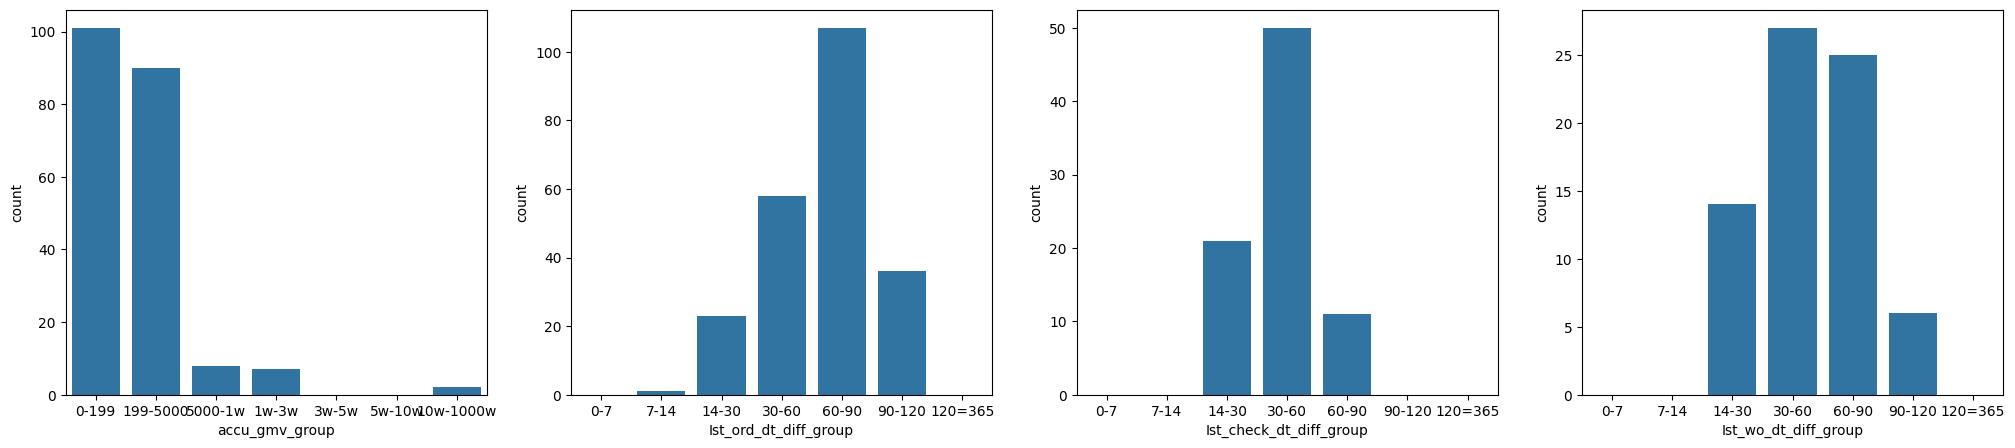

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(25, 5))
sns.countplot(data1,x='accu_gmv_group', ax= axes[0])
sns.countplot(data1,x='Ist_ord_dt_diff_group', ax= axes[1])
sns.countplot(data1,x='Ist_check_dt_diff_group', ax= axes[2])
sns.countplot(data1,x='Ist_wo_dt_diff_group', ax= axes[3])

In [12]:
data1.describe()  #科学技术法，e前面的数字 X 10的加号后面的数字次方

,order_cnt,check_cnt,writeoff_cnt,accu_gmv,Ist_ord_dt_diff,Ist_check_dt_diff,Ist_wo_dt_diff
count,252.000000,252.000000,252.000000,2.520000e+02,252.000000,252.000000,252.000000
mean,3.944444,0.559524,1.603175,1.703376e+04,1131.158730,6759.373016,7158.896825
std,8.611866,1.191114,6.011383,1.996336e+05,3078.111945,4673.869616,4499.550995
min,0.000000,0.000000,0.000000,0.000000e+00,13.000000,19.000000,20.000000
25%,1.000000,0.000000,0.000000,3.750000e+00,48.750000,55.000000,90.000000
50%,2.000000,0.000000,0.000000,1.000000e+02,77.500000,9999.000000,9999.000000
75%,4.000000,1.000000,1.000000,6.015000e+02,90.250000,9999.000000,9999.000000
max,105.000000,12.000000,61.000000,3.011473e+06,9999.000000,9999.000000,9999.000000


## 方法一，手工分类，对标平均值

In [22]:
data_for_model = data1.loc[:,['customer_id','accu_gmv','order_cnt','Ist_ord_dt_diff']]
data_for_model.rename(columns={'Ist_ord_dt_diff':'R','order_cnt':'F','accu_gmv':'M'},inplace=True)

In [11]:
data_for_model

,customer_id,M,F,R
0,4,0.08,4,91.0
1,11,311.06,6,117.0
2,5,3011473.49,105,78.0
3,1,1468.08,17,96.0
4,19,4250.00,22,82.0
...,...,...,...,...
247,457,0.00,0,9999.0
248,471,0.00,0,9999.0
249,466,0.00,0,9999.0
250,456,0.00,0,9999.0


In [23]:
#判断R列是否大于等于R列的平均值，将符合条件R_S列的值赋值为1,小于平均值赋值为2
data_for_model['R_S']=np.where(data_for_model['R']>=data_for_model['R'].mean(),1,2)
#同R_S赋值方法，对F_S、M_S进行赋值，但与R相反，F、M均为越大越好
data_for_model['F_S']=np.where(data_for_model['F']>=data_for_model['F'].mean(),2,1)
data_for_model['M_S']=np.where(data_for_model['M']>=data_for_model['M'].mean(),2,1)
data_for_model

,customer_id,M,F,R,R_S,F_S,M_S
0,4,0.08,4,91.0,2,2,1
1,11,311.06,6,117.0,2,2,1
2,5,3011473.49,105,78.0,2,2,2
3,1,1468.08,17,96.0,2,2,1
4,19,4250.00,22,82.0,2,2,1
...,...,...,...,...,...,...,...
247,457,0.00,0,9999.0,1,1,1
248,471,0.00,0,9999.0,1,1,1
249,466,0.00,0,9999.0,1,1,1
250,456,0.00,0,9999.0,1,1,1


In [41]:
#计算RFM综合分值
data_for_model['RFM']=data_for_model['R_S'].map(str)+data_for_model['F_S'].map(str)+data_for_model['M_S'].map(str)
# data_for_model['RFM']= (data_for_model['R_S'].astype(str)).str.cat(data_for_model['F_S'].astype(str)).str.cat(data_for_model['M_S'].astype(str))  # 相同结果
data_for_model.head()

,customer_id,M,F,R,R_S,F_S,M_S,RFM
0,4,0.08,4,91.0,2,2,1,221
1,11,311.06,6,117.0,2,2,1,221
2,5,3011473.49,105,78.0,2,2,2,222
3,1,1468.08,17,96.0,2,2,1,221
4,19,4250.00,22,82.0,2,2,1,221


In [53]:
#定义RFM综合分值与客户类型的对应关系表
CustomerType=pd.DataFrame({'RFM':['111','112','121','122','211','212','221','222'],'type':['一般挽留客户','重要挽留客户','一般保持客户','重要保持客户','一般发展客户','重要发展客户','一般价值客户','重要价值客户']},index=None)
CustomerType['label'] = (CustomerType['RFM']).str.cat(CustomerType['type'])
CustomerType.drop('type',axis=1,inplace=True)

In [40]:
data_for_model.head()

,customer_id,M,F,R,R_S,F_S,M_S
0,4,0.08,4,91.0,2,2,1
1,11,311.06,6,117.0,2,2,1
2,5,3011473.49,105,78.0,2,2,2
3,1,1468.08,17,96.0,2,2,1
4,19,4250.00,22,82.0,2,2,1


In [54]:
#将data_for_modela与RFM综合分值客户类型的对应关系表合并为一个数据框
data_for_model_final=pd.merge(data_for_model, CustomerType, on='RFM')
with pd.option_context('display.max_rows',None):
    print(data_for_model_final)

    customer_id           M    F       R  R_S  F_S  M_S  RFM      label
0             4        0.08    4    91.0    2    2    1  221  221一般价值客户
1            11      311.06    6   117.0    2    2    1  221  221一般价值客户
2             1     1468.08   17    96.0    2    2    1  221  221一般价值客户
3            19     4250.00   22    82.0    2    2    1  221  221一般价值客户
4             6      322.04    9    98.0    2    2    1  221  221一般价值客户
5            32       13.00    4   114.0    2    2    1  221  221一般价值客户
6            20      500.00    7    91.0    2    2    1  221  221一般价值客户
7            47     1695.05   17    98.0    2    2    1  221  221一般价值客户
8             7      200.08    8   100.0    2    2    1  221  221一般价值客户
9            63      103.04    4    68.0    2    2    1  221  221一般价值客户
10           64        9.00    5    96.0    2    2    1  221  221一般价值客户
11           66        6.00    6    97.0    2    2    1  221  221一般价值客户
12           67        3.00    4    96.0    2    2    1  221  22

In [43]:
# 设置字体
from matplotlib.font_manager import FontProperties
# 设置中文字体，注意路径可能会根据实际情况有所调整
font_path = r'C:\Windows\fonts\simhei.TTF'  # 这是思源宋体在 Ubuntu 下的路径，Windows 下路径会有所不同
font_prop = FontProperties(fname=font_path)

# 设置全局中文字体
plt.rcParams['font.family'] = font_prop.get_name()
# 设置 Seaborn 样式和字体
sns.set(font=font_prop.get_name())

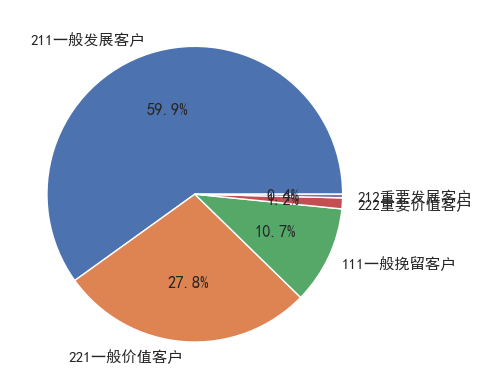

label
211一般发展客户    151
221一般价值客户     70
111一般挽留客户     27
222重要价值客户      3
212重要发展客户      1
Name: count, dtype: int64


In [56]:
#RMF模型可视化
final = data_for_model_final['label'].value_counts()
plt.pie(final,labels= final.index,autopct='%.1f%%')
plt.show()
print(final)

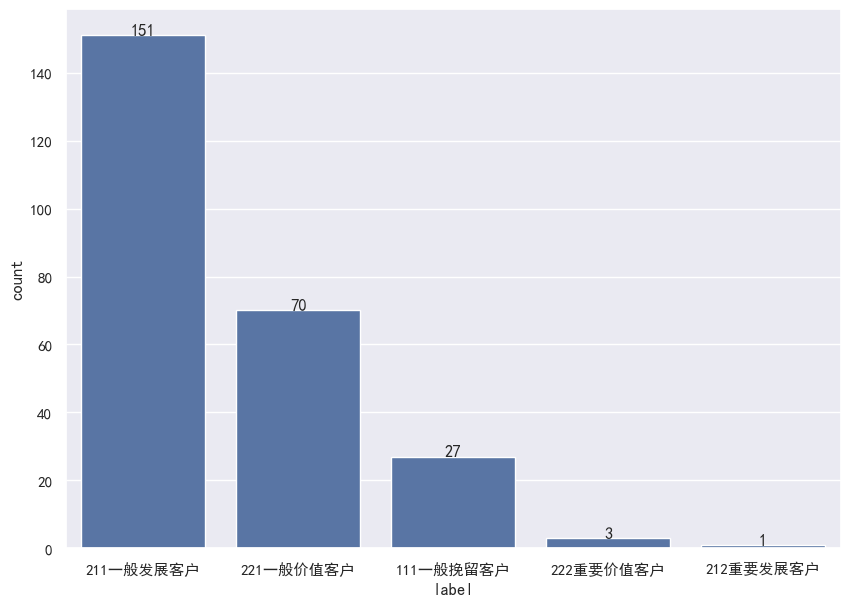

In [63]:
#RMF模型结果可视化
plt.figure(figsize=(10, 7))
v = data_for_model_final['label'].value_counts()
ax = sns.countplot(x=data_for_model_final['label'],order=v.index)
#在图像上绘制数值
for x,y in enumerate(v):
    text = ax.text(x,y,y)
    #文本数据居中对齐
    text.set_ha('center')

## 方法二，K-Means 聚类

In [65]:
data_for_model_kmeans = data1.loc[:,['accu_gmv','order_cnt','Ist_ord_dt_diff']]
data_for_model_kmeans.rename(columns={'Ist_ord_dt_diff':'R','order_cnt':'F','accu_gmv':'M'},inplace=True)
data_for_model_kmeans.head()

,M,F,R
0,0.08,4,91.0
1,311.06,6,117.0
2,3011473.49,105,78.0
3,1468.08,17,96.0
4,4250.00,22,82.0


In [66]:
#由于RFM量纲不同，可能导致聚类结果不好，所以我们先进行数据标准化
from sklearn.preprocessing import StandardScaler
#采用StandardScaler方法对数据规范化：均值为0，方差为1的正态分布,z = (x - μ) / σ
g = StandardScaler()  
stand_data = g.fit_transform(data_for_model_kmeans)
stand_data

array([[-8.54945025e-02,  6.46388547e-03, -3.38593501e-01],
       [-8.39336485e-02,  2.39163762e-01, -3.30129955e-01],
       [ 1.50295295e+01,  1.17578077e+01, -3.42825274e-01],
       [-7.81263965e-02,  1.51901309e+00, -3.36965896e-01],
       [-6.41635345e-02,  2.10076278e+00, -3.41523190e-01],
       [-8.38785383e-02,  5.88213578e-01, -3.36314854e-01],
       [-8.54296551e-02,  6.46388547e-03, -3.31106518e-01],
       [-8.54848657e-02, -3.42585930e-01, -3.30780997e-01],
       [-8.54748274e-02, -2.26235991e-01, -3.30780997e-01],
       [-8.47420322e-02, -3.42585930e-01, -3.30780997e-01],
       [-8.54898849e-02, -1.09886053e-01, -3.38919022e-01],
       [-8.54949040e-02, -2.26235991e-01, -3.36314854e-01],
       [-8.29853311e-02,  3.55513701e-01, -3.38593501e-01],
       [-7.69872010e-02,  1.51901309e+00, -3.36314854e-01],
       [-8.44906733e-02,  4.71863639e-01, -3.35663812e-01],
       [-8.54949040e-02, -2.26235991e-01, -3.36640375e-01],
       [-8.54948538e-02, -3.42585930e-01

In [67]:
data_for_model_kmeans_stand = pd.DataFrame(stand_data,columns=data_for_model_kmeans.columns,index=data_for_model_kmeans.index)
data_for_model_kmeans_stand.head()

,M,F,R
0,-0.085495,0.006464,-0.338594
1,-0.083934,0.239164,-0.330130
2,15.029530,11.757808,-0.342825
3,-0.078126,1.519013,-0.336966
4,-0.064164,2.100763,-0.341523


C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\clus

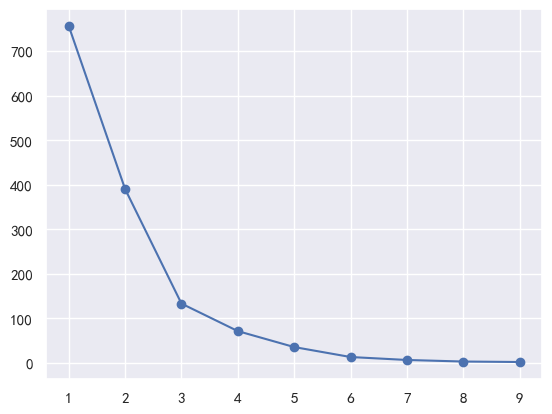

In [69]:
#根据最小的SSE原则确定簇数量，选择最佳的K值，即客户的类别数量
from sklearn.cluster import KMeans
#定义SSE列表，用来存放不同K值下的SSE
SSE = []
#定义候选K值
for i in range(1,10):
    kmeans = KMeans(n_clusters = i,random_state = 12)    # 随机种子
    kmeans.fit(data_for_model_kmeans_stand)
    SSE.append(kmeans.inertia_)
#使用手肘法看K值
plt.plot(range(1,10),SSE,marker = 'o')
plt.show()

In [78]:
#使用轮廓系数看K值:轮廓系数是描述簇内外差异的关键指标,越接近1，聚类效果越好
from sklearn.metrics import silhouette_score
kc = KMeans(n_clusters=4,random_state=12)
kc.fit(data_for_model_kmeans_stand)
silhouette_score(data_for_model_kmeans_stand,kc.labels_)

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.8476622929066511

In [79]:
#使用轮廓系数看K值:轮廓系数是描述簇内外差异的关键指标,越接近1，聚类效果越好
from sklearn.metrics import silhouette_score
kc = KMeans(n_clusters=3,random_state=12)
kc.fit(data_for_model_kmeans_stand)
silhouette_score(data_for_model_kmeans_stand,kc.labels_)

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


0.872468091340767

In [ ]:
k=3时的轮廓系数为0.87，大于k=4时的轮廓系数0.85，故k=3

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


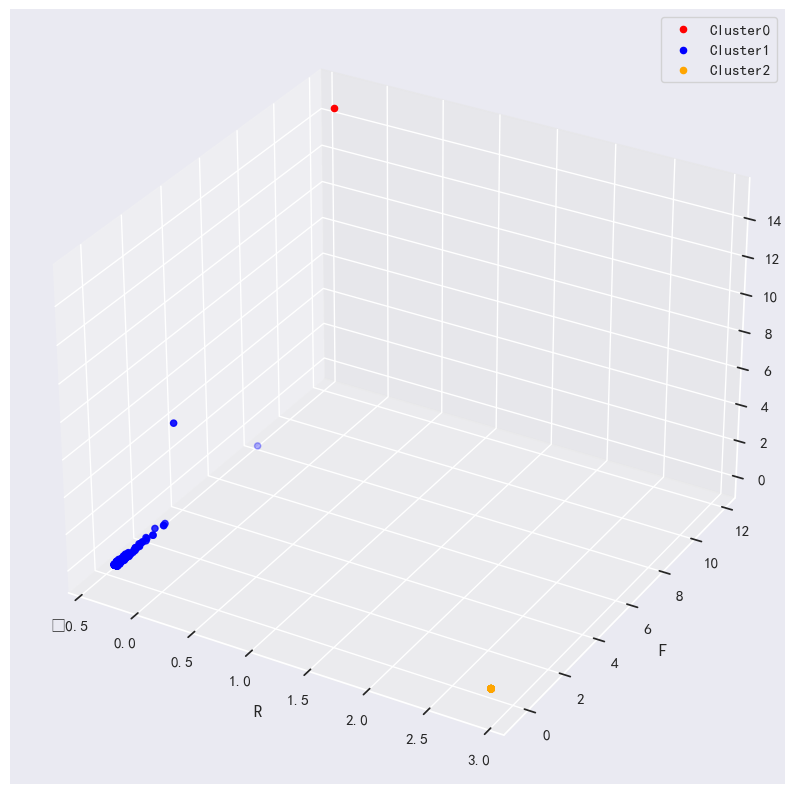

In [80]:
from mpl_toolkits.mplot3d import Axes3D  # 从matplotlib的工具包引入3d画图
#执行聚类
kmeans = KMeans(n_clusters=3,random_state=12)
result = kmeans.fit(data_for_model_kmeans_stand)   # 完成拟合，生成结果

# 将聚类标签添加到数据中
data_for_model_kmeans_stand['cluster'] = result.labels_

# 可视化
fig = plt.figure(figsize=(10,12))  ## 设置画布尺寸
ax = fig.add_subplot(111, projection='3d')   ## fig.add_subplot(111)就是构成1x1子图，第一个子图，234就是2x3个图中第4的子图，projection是投影的意思
colors = ['red', 'blue', 'orange']  # 设定三个簇的颜色

# 将聚类标签的数据类型转换为整数型
data_for_model_kmeans_stand['cluster'] = data_for_model_kmeans_stand['cluster'].astype('int')

# 根据聚类标签将数据点绘制到3D图表中
for cluster_label in range(3):  # 假设我们选择了3个簇
    cluster_data = data_for_model_kmeans_stand[result.labels_==cluster_label]
    ax.scatter(cluster_data['R'], cluster_data['F'], cluster_data['M'], c=colors[cluster_label], label=f'Cluster{cluster_label}')

#  显示图例
ax.set_xlabel('R')
ax.set_ylabel('F')
ax.set_zlabel('M')
plt.legend()   
plt.show()

In [81]:
print(data_for_model_kmeans_stand)
print(result.labels_)

             M          F         R  cluster
0    -0.085495   0.006464 -0.338594        1
1    -0.083934   0.239164 -0.330130        1
2    15.029530  11.757808 -0.342825        0
3    -0.078126   1.519013 -0.336966        1
4    -0.064164   2.100763 -0.341523        1
..         ...        ...       ...      ...
247  -0.085495  -0.458936  2.886668        2
248  -0.085495  -0.458936  2.886668        2
249  -0.085495  -0.458936  2.886668        2
250  -0.085495  -0.458936  2.886668        2
251  -0.085495  -0.458936  2.886668        2

[252 rows x 4 columns]
[1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


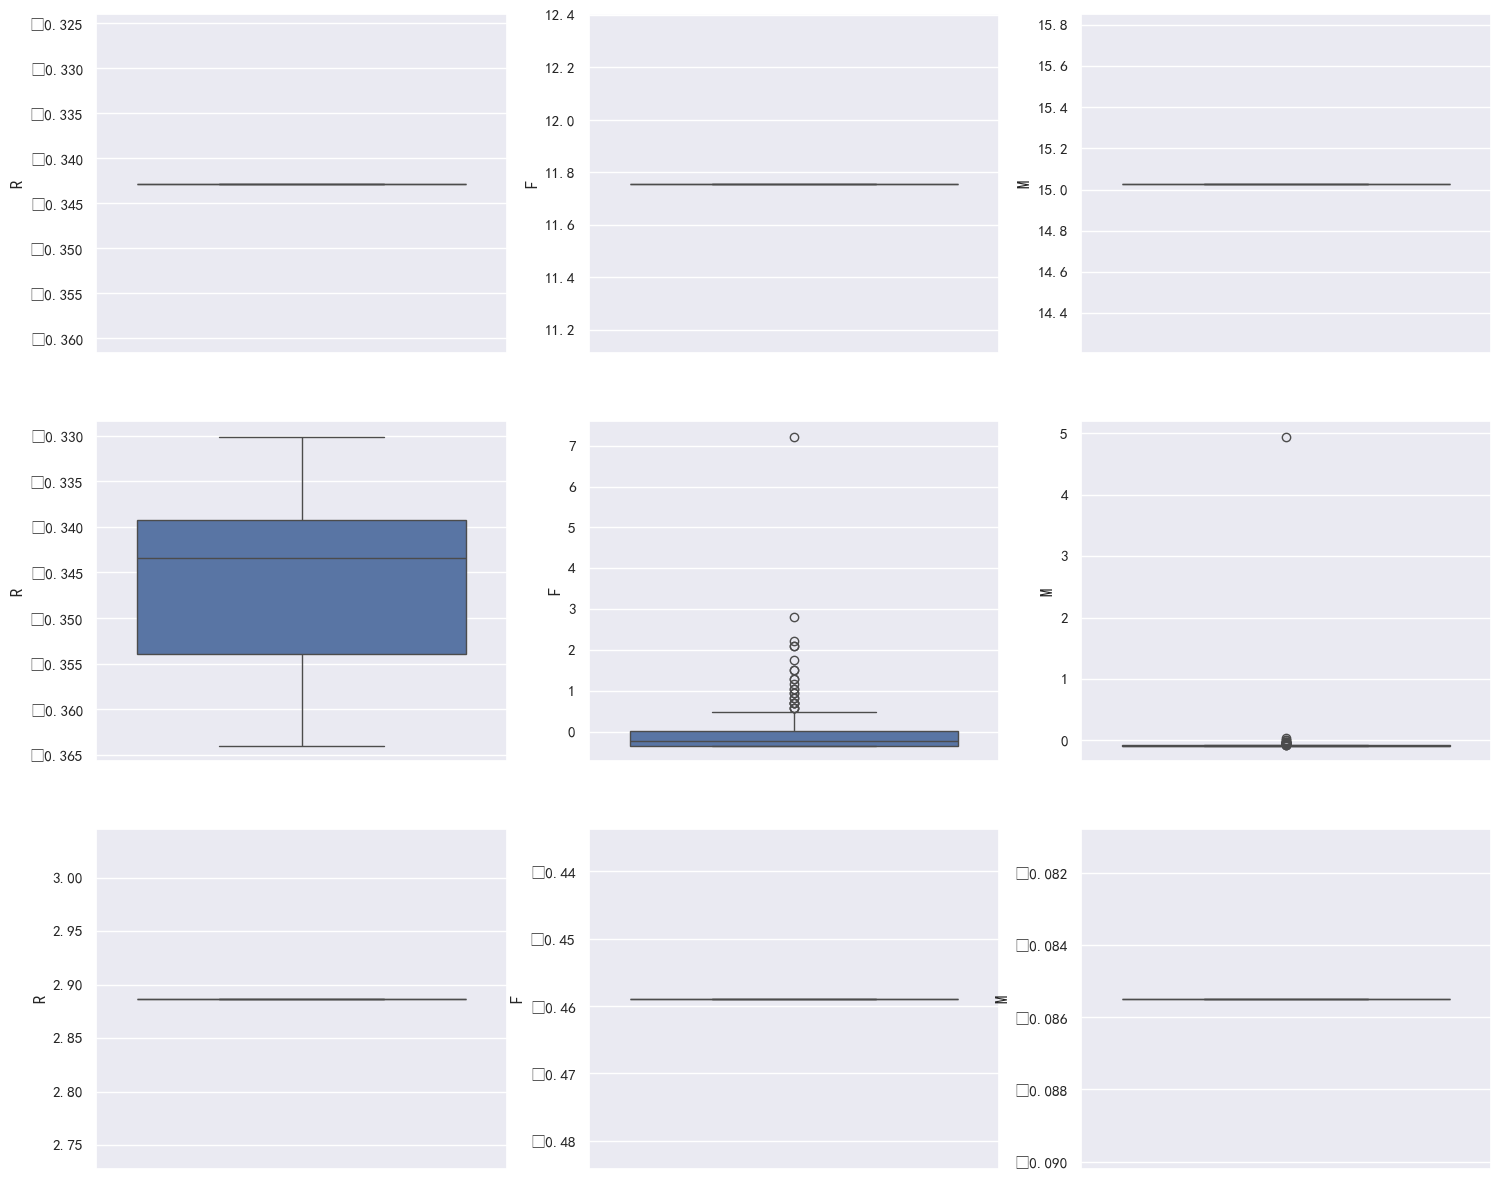

In [82]:
#客户群体分析
fig,ax = plt.subplots(3,3,figsize=(18,15))
for i in range(3):
    #获取第i个客户群的数据
    de = data_for_model_kmeans_stand[kmeans.labels_==i]
    sns.boxplot(y='R',data=de,ax=ax[i][0])
    sns.boxplot(y='F',data=de,ax=ax[i][1])
    sns.boxplot(y='M',data=de,ax=ax[i][2])

In [83]:
#执行聚类
kmeans = KMeans(n_clusters=3,random_state=12)
result = kmeans.fit(data_for_model_kmeans_stand)
#获取每个样本所属的簇，标签的数值对应所属簇的索引
print('标签:',result.labels_)
#获取SSE（簇惯性）
print('SSE:',result.inertia_)
#获取迭代次数
print('迭代次数:',result.n_iter_)
#聚类的分值，分值越大，效果越好,直接取SSE的相反数
print('分值:',result.score(data_for_model_kmeans_stand))

标签: [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
SSE: 133.27326599193952
迭代次数: 3
分值: -133.27326599193952


C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


1    224
2     27
0      1
Name: count, dtype: int64


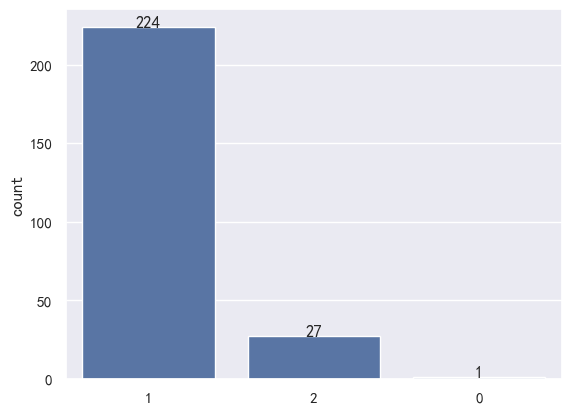

In [76]:
#统计每个类别群体的数量
qt = pd.Series(result.labels_).value_counts()
ax = sns.countplot(x=result.labels_,order=qt.index)
#在图像上绘制数值
for x,y in enumerate(qt):
    text = ax.text(x,y,y) #x,y为填入文本的坐标，y是填充数值
    text.set_ha('center')
print(qt)

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


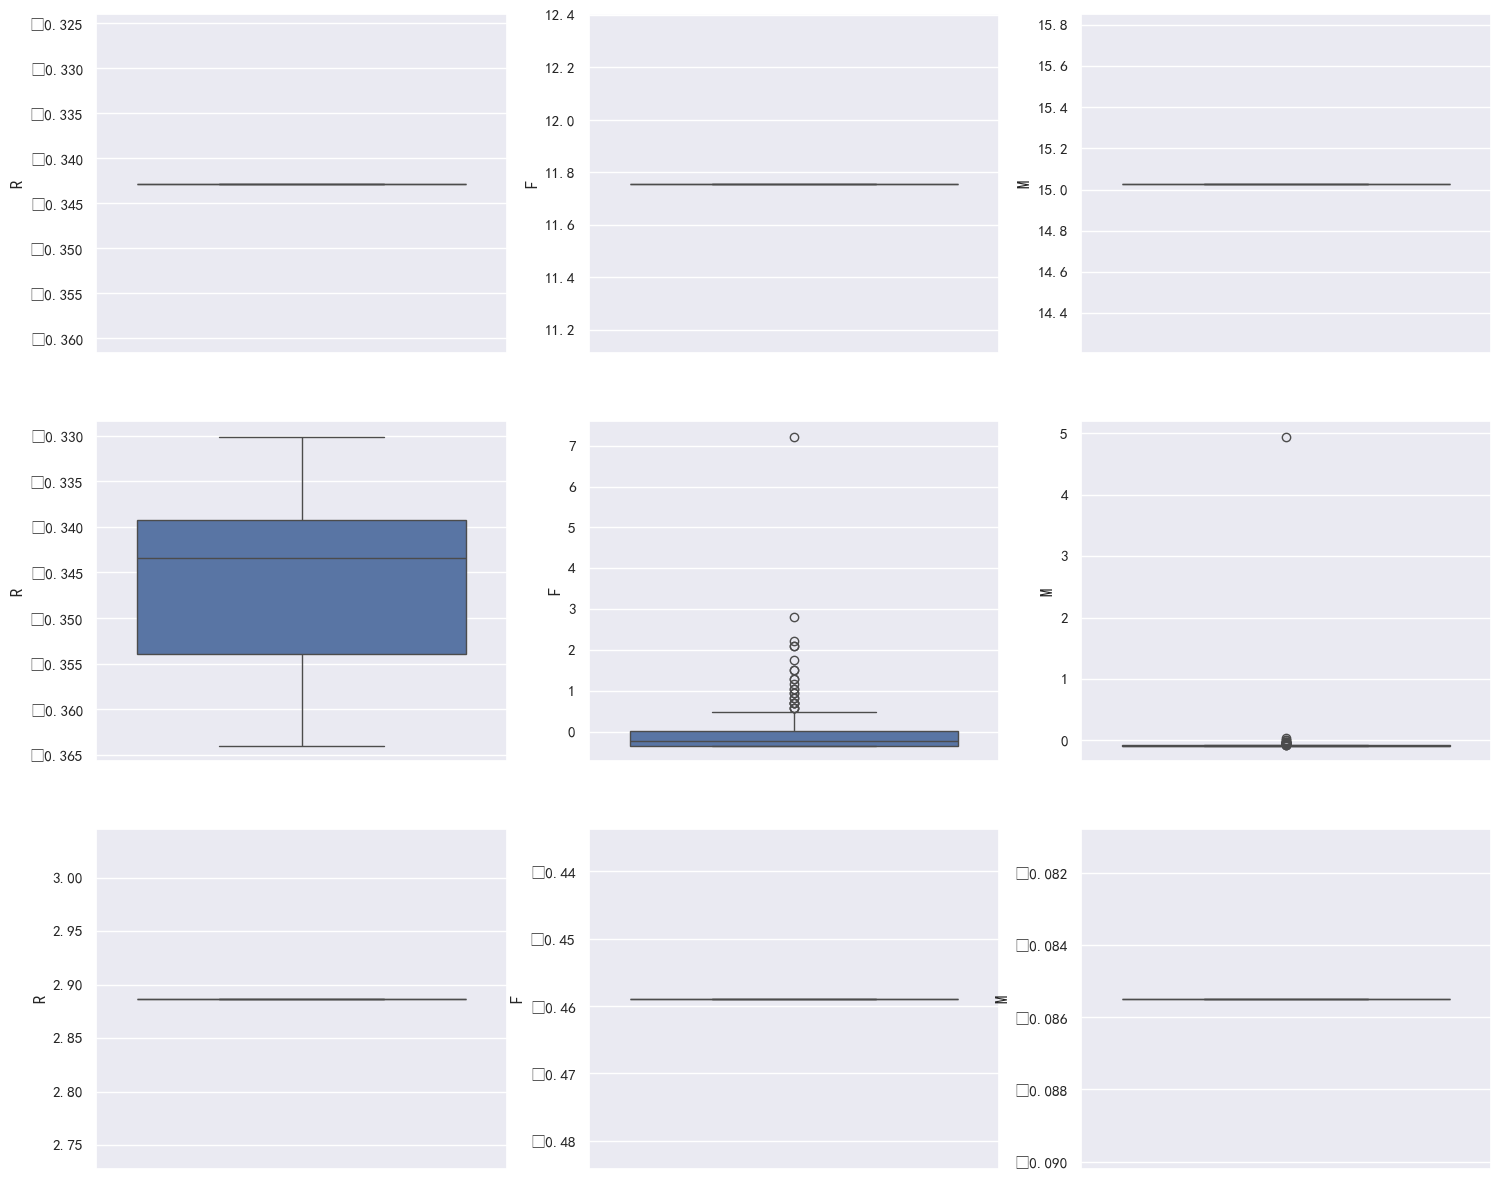

In [77]:
#客户群体分析
fig,ax = plt.subplots(3,3,figsize=(18,15))
for i in range(3):
    #获取第i个客户群的数据
    de = data_for_model_kmeans_stand[data_for_model_kmeans_stand['cluster']== i]
    sns.boxplot(y='R',data=de,ax=ax[i][0])
    sns.boxplot(y='F',data=de,ax=ax[i][1])
    sns.boxplot(y='M',data=de,ax=ax[i][2])